In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


讀取資料

In [7]:
file_path= '/Users/user/Desktop/water_kernel/'
file_name= 'Taichung_data.xlsx'
df_water_consum= pd.read_excel(file_path+file_name, sheet_name='月用水量')
df_consumer_index= pd.read_excel(file_path+file_name, sheet_name='消費者物價指數')
df_mon_temp= pd.read_excel(file_path+file_name, sheet_name='月平均氣溫')
df_mon_rain= pd.read_excel(file_path+file_name, sheet_name='月雨量')
df_solar_hour= pd.read_excel(file_path+file_name, sheet_name='日照時數')

#將資料格式轉成numpy
water_consum= df_water_consum.values[0:180]
consumer_index= df_consumer_index.values[0:180]
mon_temp= df_mon_temp.values[0:180]
mon_rain= df_mon_rain.values[0:180]
solar_hour= df_solar_hour.values[0:180]
water_consum_time=[]

#轉換日期格式
for i in range(len(water_consum)):
  water_consum_time.append(str(int(water_consum[i][0][0:2])+1911)+water_consum[i][0][2:])
  water_consum_time[i] = datetime.datetime.strptime(water_consum_time[i],'%Y,%m')
  
water_consum_volume= [water_consum[i][1] for i in range(len(water_consum))] 
consumer_index_ID= [consumer_index[i][1] for i in range(len(water_consum))] 
mon_temp_temp= [mon_temp[i][1] for i in range(len(water_consum))]
mon_rain_rain= [mon_rain[i][1] for i in range(len(water_consum))]
solar_hour_hour= [solar_hour[i][1] for i in range(len(water_consum))]


C:\Users\user\Anaconda3-1\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


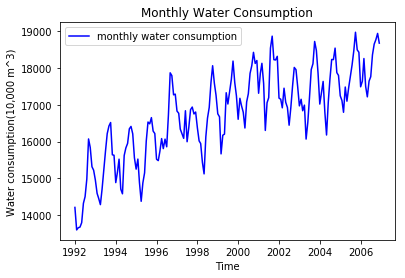

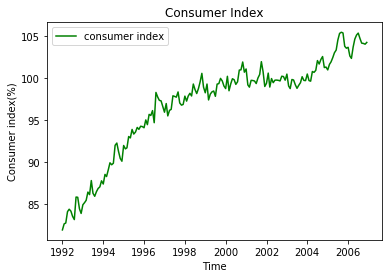

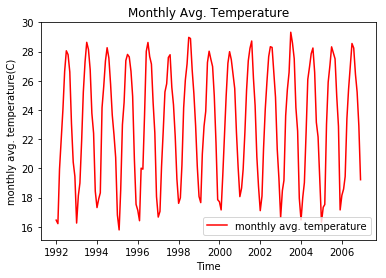

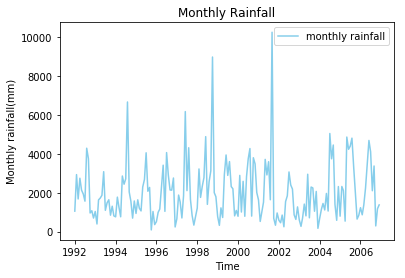

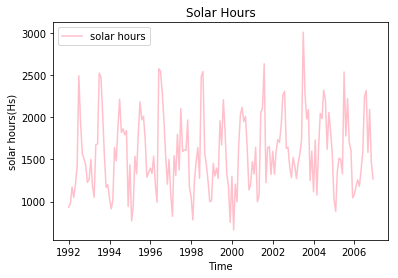

In [8]:
#繪製資料
#月用水量
plt.figure()
plt.plot(water_consum_time, water_consum_volume, 'b-', label='monthly water consumption')
plt.xlabel('Time')
plt.ylabel('Water consumption(10,000 m^3)')
plt.title('Monthly Water Consumption')
plt.legend()

#消費者物價指數
plt.figure()
plt.plot(water_consum_time, consumer_index_ID, 'g-', label='consumer index')
plt.xlabel('Time')
plt.ylabel('Consumer index(%)')
plt.title('Consumer Index')
plt.legend()

#月平均溫度
plt.figure()
plt.plot(water_consum_time, mon_temp_temp, 'r-', label='monthly avg. temperature')
plt.xlabel('Time')
plt.ylabel('monthly avg. temperature(C)')
plt.title('Monthly Avg. Temperature')
plt.legend()

#月平均雨量
plt.figure()
plt.plot(water_consum_time, mon_rain_rain, color='skyblue', linestyle='-' ,label='monthly rainfall')
plt.xlabel('Time')
plt.ylabel('Monthly rainfall(mm)')
plt.title('Monthly Rainfall')
plt.legend()

#日照時數
plt.figure()
plt.plot(water_consum_time, solar_hour_hour, color='pink', linestyle='-' ,label='solar hours')
plt.xlabel('Time')
plt.ylabel('solar hours(Hs)')
plt.title('Solar Hours')
plt.legend()

In [10]:
#計算用水量變化
water_consum_volume=np.array(water_consum_volume)
diff_water_comsum_volume=water_consum_volume[1:len(water_consum_volume)]-water_consum_volume[0:len(water_consum_volume)-1] 


# 計算基底矩陣

In [11]:
Basis_num=41 #正交基底矩陣寬度（月用水量 v.s. 消費者物價指數、月平均溫度、月平均雨量、月日照時數，自然頻率+每項五階）
Basis_water_cosum= np.zeros((len(diff_water_comsum_volume), Basis_num))
factor=[consumer_index_ID, mon_temp_temp, mon_rain_rain, solar_hour_hour]
r=5  #函數階層/解析度

for i in range(len(diff_water_comsum_volume)):
    Basis_water_cosum[i][0] = 1
    
    for j in range(1, 6):
        Basis_water_cosum[i][j] = np.sin( j*( consumer_index_ID[i+1] - water_consum_volume[i+1] ) ) 
    for j in range(6, 11):
        Basis_water_cosum[i][j] = np.cos( (j-r)*( consumer_index_ID[i+1] - water_consum_volume[i+1] ) )
    for j in range(11,16):
        Basis_water_cosum[i][j] = np.sin( (j-1*2*r)*( mon_temp_temp[i+1] - water_consum_volume[i+1] ) )
    for j in range(16,21):
        Basis_water_cosum[i][j] = np.cos( (j-1*2*r-r)*( mon_temp_temp[i+1] - water_consum_volume[i+1] ) )
    for j in range(21,26):
        Basis_water_cosum[i][j] = np.sin( (j-2*2*r)*( mon_rain_rain[i+1] - water_consum_volume[i+1] ) )
    for j in range(26,31):   
        Basis_water_cosum[i][j] = np.cos( (j-2*2*r-r)*( mon_rain_rain[i+1] - water_consum_volume[i+1] ) )
    for j in range(31,36):
        Basis_water_cosum[i][j] = np.sin( (j-3*2*r)*( solar_hour_hour[i+1] - water_consum_volume[i+1] ) )
    for j in range(36,Basis_num):    
        Basis_water_cosum[i][j] = np.cos( (j-3*2*r-r)*( solar_hour_hour[i+1] - water_consum_volume[i+1] ) )    

      

# 求取係數矩陣

In [12]:
training_endloc = 100 
Coefficient_water_consum = np.dot(np.linalg.pinv(Basis_water_cosum[:training_endloc]), diff_water_comsum_volume[:training_endloc])



In [13]:
#計算預測結果
Estimate_diff_water_consum=np.dot(Basis_water_cosum, Coefficient_water_consum)

Estimate_water_consum_volume=np.zeros(len(water_consum_volume))
Estimate_water_consum_volume[0]=water_consum_volume[0]

for i in range(len(diff_water_comsum_volume)):
    Estimate_water_consum_volume[i+1]=water_consum_volume[i]+int(Estimate_diff_water_consum[i])



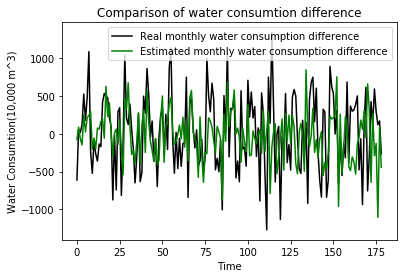

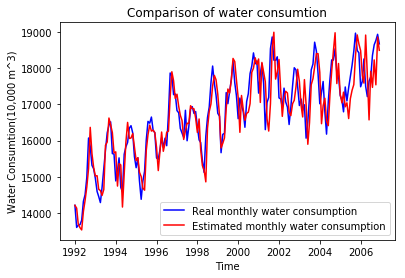

In [34]:
#繪製實際用水變化量與與預測用水變化量
Timestep=[i for i in range(len(diff_water_comsum_volume))]
plt.figure()
plt.plot(Timestep, diff_water_comsum_volume, 'k-', label='Real monthly water consumption difference')
plt.plot(Timestep, Estimate_diff_water_consum, 'g-', label='Estimated monthly water consumption difference')
plt.xlabel('Time')
plt.ylabel('Water Consumtion(10,000 m^3)')
plt.title('Comparison of water consumtion difference')
plt.legend()

#繪製實際用水量與預測用水量
plt.figure()
plt.plot(water_consum_time, water_consum_volume, 'b-', label='Realization monthly water consumption')
plt.plot(water_consum_time, Estimate_water_consum_volume, 'r-', label='Estimated monthly water consumption')
plt.xlabel('Time')
plt.ylabel('Water Consumtion(10,000 m^3)')
plt.title('Comparison of water consumtion')
plt.legend()